## Neural Networks for Data Science Applications (2019/2020)
## Final exam

* **Student(s)**: Nurassilova Omirbanu (1848425).
* **Reference paper**: Johnson R., Zhang T., 2015. Effective Use of Word Order for Text Categorizationwith Convolutional Neural Networks.



## Part 1: Report

#### Introduction

Convolutional Neural Network (CNN) was used in order to implement text categorization such as sentiment classification and topic categorization.  This task is done with texts which written  in natural languages with pre-defined categories. The code for this paper was written in c++ in 2015. And it was released as a tool on their web-site.

Previous works used bag-of-word vectors to represent text documents (text embedding), where we take into account if words exist in the document or not. But we lose word order which is important in sentiment classification. There were methods to keep word order by using n-grams (sequence of n words as one unit), but it was not effective also.

##### Novelty

1. The main novelties are that authors use convolutional neural networks(CNN):
    1. to keep word order
    2. to have word embedding as a part of the training of the whole network. They don’t use external word embedders.
2. The technical novelty of using dynamic max-pooling layer to get constant sized output. We need it because text documents size varies, while finally, fully connected layers need constant sized input  to construct classifiers.


##### used dataset
In this paper several databases were studied. For this project IMDB data was used. This dataset contains 50k entries of data with positive and negative comments about movies. In our case model should predict if text contains positive or negative review. We tried to reimplement small experiments with two variants of input structure in python using Tensorflow. They are seq-CNN and bow-CNN for text. Text was cleaned and top 30k words were saved. But in order to reduce computation time we used only 5k words. For each word in the text we will have one vector with dim (5k,1) where all the entries will be zeros and only one value equal to 1 if this word is in top 5k list otherwise 0. So for each text we will have a matrix with dimension (number of words in one document, 5k).

#### Experiments

The standard CNN structure was used to compute convolutions for small regions vectors by moving orderly along input data. As an input they take 1D structured documents with initial word order, where a small region vectors corresponds to a sequence of words. To transform sequence of words to region vectors they had two methods: seq-CNN and bow-CNN. Sequences of words are taken as on the picture below:

![seq_words](conseq.png)

#### seq-CNN for text

In this case input organized in a way where two vectors of two consequtive words concatenated on axis 1 and we have as input for convolution vector with dimension (2*length of the vector of one word, 1). So we can say that our region size is 2. Of course it can be other values but it makes the computation time more. The stride value should be 1 in this case. The main idea of this type of organization of the input is to save the order of words in the text. The window size in convolutional layer is 1 for this CNN.

#### bow-CNN for text

We have a problem related to the size of the input in the previous seq-CNN because of the value of region size r. The size of the input will be multiplied with r. In order to prevent having so huge matrixes we can use another variation offered in this paper. If we are assuming that the region size is 2 then we can put window size equal to region size in tensorflow function for creating convolutional layer of the network. In this way we can keep the idea to take each consequent pair of words vectors going together to convolutional layer.

## Part 2: External libraries

In [1]:
import pandas as pd 
import numpy as np 
import re
import os
from tqdm.notebook import tqdm
import json
import string
from multiprocessing import Pool
import operator
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# https://ai.stanford.edu/~amaas/data/sentiment/ 
import h5py
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
np.random.seed(1848425*9)

## Part 3: Implementation

1. Data cleaning part contains converting words to lowercase letters, then removing punctuation and stemmimg.
2. Then words were sorted by their occurences in texts, the most popular 30k was saved into file.
3. Experiments part contains implementation of two CNN with different versions of input matrixes.

#### data cleaning

In [ ]:
def cleaning_words(path):
    file = open(path, 'rt')
    text = file.read()
    file.close()
    # split into words
    text = re.sub(r'http\S+', '', text)
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    #print(tokens[:100], '\n')
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    #print("without punctuations: ", stripped[:100], '\n')
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    #print("not alph: ", words[:100], '\n')
    # filter out stop words
    stop_words = stopwords.words('english')
    #words = [w for w in words if not w in names_authors_lower]
    words = [w for w in words if not w in stop_words]
    #print("without stop words: ", words[:100], '\n')
    #find bigram
    
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    return stemmed

In [ ]:
set_list = ["train", "test"]
word_count_dict = {}
all_text ={}


def word_cleaner(text_set):
    root_path = os.path.join("aclImdb", text_set)
    all_text[text_set]= {}
    for path, _, fnames in os.walk(root_path):
        print(path)
        pbar = tqdm(total=25000, desc = "total {} set number: {}".format(text_set, 25000))
        for fname in fnames:
            if fname.endswith("txt"):
                path_file = os.path.join(path,fname)
                text = cleaning_words(path_file)
                sense = path.split("/")[-1]
                if sense not in all_text[text_set]:
                    all_text[text_set][sense]={}
                
                all_text[text_set][sense][fname] = text
                #save_path = os.path.join("processed", text_set,sense )
                #os.makedirs(save_path, exist_ok = True)
                #with open(os.path.join(save_path,fname), "w") as file:
                    #file.write(text)
                
                
                for word in text:
                    if not word in word_count_dict:
                        word_count_dict[word] = 1
                    else:
                        word_count_dict[word] += 1
                pbar.update(1)
                
        pbar.close()
                        
for text_dir in set_list:
    word_cleaner(text_dir)
with open('word_count_dict.json', 'w') as f:
    json.dump(word_count_dict, f)
with open('all_text.json', 'w') as f:
    json.dump(all_text, f)

##### Sorting data
getting top 30k popular words among texts

In [ ]:
with open('word_count_dict.json') as json_file:
    data = json.load(json_file)
    
sorted_data  = {k: v for k, v in sorted(data.items(), key=lambda item: item[1],reverse=True)}
del sorted_data['br']
del sorted_data['nt']
top_30K_words_dict = dict(list(sorted_data.items())[:30000])

list_words = list(sorted_data.keys())[:30000]
top_30K_words ={}
for i in range(30000):
    top_30K_words[list_words[i]] = i
    
with open("top_30K_words_dict.json", "w") as f:
    json.dump(top_30K_words_dict, f)
with open("top_30K_words.json", "w") as f:
    json.dump(top_30K_words, f)
with open('all_text.json') as json_file:
    all_text = json.load(json_file)

## Experiments

Taking the data that are processed in the project

In [2]:
with open('all_text.json') as json_file:
    all_text = json.load(json_file)
with open('top_30K_words.json') as json_file:
    top_30K_words = json.load(json_file)

In [3]:
NNN = 5000
top_5K = dict(list(top_30K_words.items())[:NNN])

For our project 5000 most popular words among texts in our dataset were chosen.

Our dataset contained 50k texts.
For train we took 20k of them.
and For test 4k.

In [4]:
pos_list = np.random.choice(list(all_text['train']['pos'].keys()),10000)
neg_list = np.random.choice(list(all_text['train']['neg'].keys()),10000)
pos_list_test = np.random.choice(list(all_text['test']['pos'].keys()),2000)
neg_list_test = np.random.choice(list(all_text['test']['neg'].keys()),2000)

In [5]:
target_label = [1]*2000
tt = [0]*2000

In [6]:
target_label.extend(tt)

In [7]:
lens_l = []
for x in pos_list_test:
    lens_l.append(len(all_text['test']['pos'][x]))
for x in neg_list_test:
    lens_l.append(len(all_text['test']['neg'][x]))

In [8]:
test_set = list(pos_list_test)
test_set.extend(neg_list_test)

We could not implement dynamic max_pooling as it is done in paper because we had retracing warning in executing training the model with different dimensions of input as authors of the paper did. That is why we decided to use the same dimension of inputs. In order to do that we added zero vectors to the text matrixes that we have. But we needed to decide which number to take.
In order to define the dimension value (the length of the text that we will consider) we looked to lengthes of all texts. As we see below the max length is 1168, but it doesnot make sense to use this number and produce huge matrixes. At the end we picked 450 as the constant first dimension of the input.

In [9]:
lens_list = [] # we calculated all lengthes in order to decide which number use to limit dimestion of our matrixes
for x in pos_list:
    lens_list.append(len(all_text['train']['pos'][x]))
for x in neg_list:
    lens_list.append(len(all_text['train']['neg'][x]))

In [10]:
np.quantile(lens_list, 0.98) # we looked to the quantile, so we decided to use 450

419.0

In [11]:
np.quantile(lens_l, 0.98)

406.02

In [12]:
np.max(lens_l)

1168

In [13]:
from sklearn.metrics import confusion_matrix
# the following method is calculating accuracy
def pred_error(y,y_pred):    
    conf_mat = confusion_matrix(y,y_pred)
    accuracy = sklearn.metrics.accuracy_score(y, y_pred)
    err = 1-accuracy
    return err, conf_mat, accuracy

### seq-CNN
#### first model
According to the paper network should have input,convolution, maxpooling and output layer.
The following functions perform several tasks. Here the input matrix is concatenated with itself but from the second row by axis 1 in order to implement sequential CNN where order of words is saved and input of convolution is each pair of consequtive words in the text. We will put kernel size as 1 so convolutional layer will consider one row of the matrix at a time. Each row looks like the example above:

![seq-input](seq.png)

In [15]:
def text_selection_train(): # this procedure takes sample at random from the train set
    z = np.random.uniform()
    if z>0.5:
        text_id = np.random.choice(pos_list, 1)
        sense = "pos"
        
    else: 
        text_id = np.random.choice(neg_list, 1)
        sense = "neg"
    return (text_id, sense)

In [16]:
def text_matrix_seq(text_id, sense, data_set = "train"): # this method is creating a matrix for input
    text = all_text[data_set][sense][text_id]
    N = len(text)
    if N <= 450: # in case if we have less words than 450 in one text
        text_array = np.zeros((450, NNN))
    else:
        text_array = np.zeros((450, NNN))
        N = 450
    for i in range(N):
        if text[i] in top_5K.keys(): # put 1 in the matrix according to order in top 5k if word is there
            index = top_5K[text[i]]
            text_array[i,index] = 1
    seqq = np.zeros((450,NNN))
    seqq[0:449,] = text_array[1:450,]
    final = np.concatenate((text_array, seqq), axis = 1) # concatenating 2 vectors (consequtive 2 words in text)
    # in a way that 2 words merged together in one line, so length of the vector doubled in each row
    # and repeating it for all words in the text
    return final

       
def one_text_generator_2():
    text_id, sense = text_selection_train() # selecting a document/text
    #print(text_id)
    text_array = text_matrix_seq(text_id[0], sense) # obtaining a matrix for input
    if sense == 'pos':
        sense = 1
    else:
        sense = 0
    return text_array, sense   

def model2(ff,kk,ss,pp): # function which creates a model
    inputs = tf.keras.layers.Input( shape=(450,NNN*2), dtype=tf.float32)
    #inputs = tf.keras.Sequential()
    x = tf.keras.layers.Conv1D(filters=ff,kernel_size=kk,strides=ss, activation='relu', padding ="SAME")(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=pp)(x)#tf.keras.layers.Lambda(max_pool=4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    return tf.keras.Model(inputs = inputs, outputs = x)

net_conv2 = model2(1000,1,1,10) # creating a model
net_conv2.summary()
loss_object =  tf.keras.losses.BinaryCrossentropy(from_logits =True) # loss function
net_conv2_optimizer =tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # optimizer

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 10000)]      0         
_________________________________________________________________
conv1d (Conv1D)              (None, 450, 1000)         10001000  
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 45, 1000)          0         
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 45001     
Total params: 10,046,001
Trainable params: 10,046,001
Non-trainable params: 0
_________________________________________________________________


In [17]:
@tf.function
def train_step(one_text, target):
    # function for training, we are traing one text per session
    with tf.GradientTape() as tape:
        prediction = net_conv2(one_text,training=True) 
        loss = loss_object(target, prediction)
        gradients = tape.gradient(loss, net_conv2.trainable_weights)
        net_conv2_optimizer.apply_gradients(zip(gradients, net_conv2.trainable_weights))
        return loss

def fit_function(steps = 5000):
    losses = [] # loss history
    for step in tqdm(range(steps)):
        
        one_text, target = one_text_generator_2() # generating an input
        
        #print("len text: ", len(one_text))
        one_text, target = tf.cast(one_text, tf.float32),tf.cast(target, tf.float32)
        one_text, target = tf.expand_dims(one_text, 0),tf.expand_dims(target, 0)
        loss = train_step(one_text, target) # training
        losses.append(loss.numpy())
        #print("Loss: ", loss.numpy())
    return losses

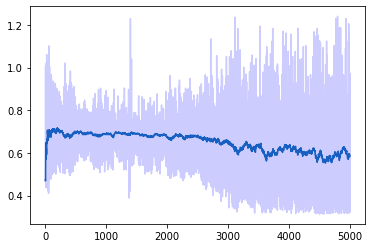

In [18]:
losses2 = fit_function()
loss_pd = pd.Series(losses2).ewm(halflife=50)
plt.plot(loss_pd.mean())
plt.plot(losses2, 'b', alpha=0.2)

#### test of seq-CNN
In this step we tested trained above model.

In [19]:
def testing(): # testing part
    targets=[]
    answ = []
    step =len(test_set)
    steps = np.random.choice(range(len(test_set)),1500) # choosing random 1500 texts from test set
    for i in tqdm(steps):    
        text_id, sense = test_set[i], target_label[i]
        #print(text_id)
        target = sense
        if sense == 1:
            sense = 'pos'
        else:
            sense = 'neg'
        one_text = text_matrix_seq(text_id, sense, data_set="test")
        one_text = tf.cast(one_text, tf.float32)
        one_text= tf.expand_dims(one_text, 0)
        answ.append(int(round(net_conv2.predict(one_text)[0][0]))) # predicting
        targets.append(target)
    #print(answ)
    print(np.sum(targets)) # the number of positive comments # just to be sure that data is balanced
    #print(answ)
    #print(targets)
    answ = np.array(answ)
    targets = np.array(targets)
    print (np.sum(np.array((answ - targets))**2)/len(steps)) # error rate
    return (pred_error(targets,answ))

In [20]:
(err, conf_mat, accuracy)=testing()
# 776 it is the number of positive comments that model predicted # just to be sure that targets are balanced
# then this function is printing error rate


776
0.17133333333333334


In [21]:
accuracy # accuracy value on the test

0.8286666666666667

### bow-CNN
#### second model

The main difference from the first model is that input size is less for 2 times because we are not concatenating matrixes. And kernel size is 2 in convolutional layer. In order to make as an input for the convolutional layer the pair of consequtive words but without saving the order. However, according to the paper order is saved since we are considering consequrive pairs. All the procedures in this section are the same as in the previous except for matrix maker function. Additionally, we are giving different parameters to a model. Sequences of words considered here as in the picture below:

![bow](bow.png)

In [16]:

def text_matrix_BOW(text_id, sense, data_set = "train"):
    text = all_text[data_set][sense][text_id]
    N = len(text)
    if N <= 450:
        text_array = np.zeros((450, NNN))
    else:
        text_array = np.zeros((450, NNN))
        N = 450
    for i in range(N):
        if text[i] in top_5K.keys():
            index = top_5K[text[i]]
            text_array[i,index] = 1
    return text_array

In [17]:
       
def one_text_generator():
    text_id, sense = text_selection_train()
    #print(text_id)
    text_array = text_matrix_BOW(text_id[0], sense)
    if sense == 'pos':
        sense = 1
    else:
        sense = 0
    return text_array, sense   

In [18]:
def model(ff,kk,ss,pp):
    inputs = tf.keras.layers.Input( shape=(450,NNN), dtype=tf.float32)
    #inputs = tf.keras.Sequential()
    x = tf.keras.layers.Conv1D(filters=ff,kernel_size=kk,strides=ss, activation='relu', padding ="SAME")(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=pp)(x)#tf.keras.layers.Lambda(max_pool=4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    return tf.keras.Model(inputs = inputs, outputs = x)

In [19]:
net_conv = model(1000,2,1,10) # BOW
net_conv.summary()
loss_object =  tf.keras.losses.BinaryCrossentropy(from_logits =True)
net_conv_optimizer =tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 5000)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 450, 1000)         10001000  
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 45, 1000)          0         
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 45001     
Total params: 10,046,001
Trainable params: 10,046,001
Non-trainable params: 0
_________________________________________________________________


In [20]:
@tf.function
def train_step(one_text, target):
    
    with tf.GradientTape() as tape:
        prediction = net_conv(one_text,training=True) 
        loss = loss_object(target, prediction)
        gradients = tape.gradient(loss, net_conv.trainable_weights)
        net_conv_optimizer.apply_gradients(zip(gradients, net_conv.trainable_weights))
        return loss

In [21]:
def fit_function(steps = 5000):
    losses = []
    for step in tqdm(range(steps)):
        
        one_text, target = one_text_generator()
        
        #print("len text: ", len(one_text))
        one_text, target = tf.cast(one_text, tf.float32),tf.cast(target, tf.float32)
        one_text, target = tf.expand_dims(one_text, 0),tf.expand_dims(target, 0)
        loss = train_step(one_text, target)
        losses.append(loss.numpy())
        #print("Loss: ", loss.numpy())
    return losses

In [22]:
losses = fit_function()

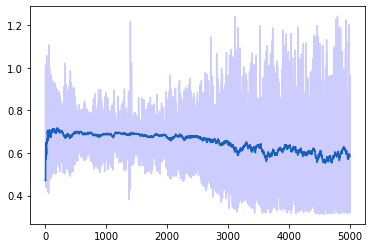

In [23]:
loss_pd = pd.Series(losses).ewm(halflife=50)
plt.plot(loss_pd.mean())
plt.plot(losses, 'b', alpha=0.2)

#### test of bow-CNN
testing of the second model

In [24]:
def testing():
    targets=[]
    answ = []
    step =len(test_set)
    steps = np.random.choice(range(len(test_set)),1500)
    for i in tqdm(steps):    
        text_id, sense = test_set[i], target_label[i]
        #print(text_id)
        target = sense
        if sense == 1:
            sense = 'pos'
        else:
            sense = 'neg'
        one_text = text_matrix_BOW(text_id, sense, data_set="test")
        one_text = tf.cast(one_text, tf.float32)#,tf.cast(target, tf.float32)
        one_text= tf.expand_dims(one_text, 0)#,tf.expand_dims(target, 0)
        answ.append(int(round(net_conv.predict(one_text)[0][0])))
        targets.append(target)
    #print(answ)
    print(np.sum(targets))
    #print(answ)
    #print(targets)
    answ = np.array(answ)
    targets = np.array(targets)
    print (np.sum(np.array((answ - targets))**2)/len(steps))
    return (pred_error(targets,answ))

In [25]:
(err, conf_mat, accuracy)=testing()


776
0.16866666666666666


In [26]:
accuracy

0.8313333333333334

## Part 4 - Experimental evaluation

Two experiments were performed in this project using Tensorflow. In both cases structure of the Network was similar. They had several layers: input, convolution, pooling, output layers.

Their differences were in the dimension of the input and parameters of the model such as filters number, kernel size. 

In the paper authors implemented dynamic maxpooling layer without changing texts matrixes dimension. According to them in their network it was possible to put the inputs with different dimensions. I tryed to do it also in Tensorflow but I had warning message that graph was changed(retracing). That is why I decided to look at the lengthes of the texts and then I took the 450 as the value as a maximum length of my input because this value is more than the 95% quantile of lenthes. Because of it my network stopped to produce warnings.

In the paper a lot of experiments were described but since I was doing this project alone I decided to perform only two examples of them.

In the results of the paper error rate was close to 10%. I obtained value close to 20% in both cases which is not that bad if we take into consideration that I took only 5k words instead of 30k as authors did.

##### In the code below you can see my trial to implement dynamic maxpooling using Lambda function in tf

In [ ]:
def max_poolling(inputs, max_pool_units = 75, filter_n = 32):
    shape = inputs.shape
    if shape[1] is None:
        return tf.keras.layers.Input((75,32))
    else:
        if shape[1]%max_pool_units==0:
            window_size= shape[1]//max_pool_units

        else:
            window_size= shape[1]//max_pool_units +1
            adder =max_pool_units-shape[1]%max_pool_units
            add_array = tf.zeros((adder, filter_n))
            add_array = tf.expand_dims(add_array, 0)
            #print(add_array)
            inputs = tf.concat([inputs, add_array], 1) #otmetka 0

        shape = inputs.shape 
        #print(shape)
        x =tf.reshape(inputs, shape=(1, int(shape[1]/window_size), window_size, 32 )) #[300,32] = [75,4,32]
        x_max = tf.reduce_max(x, axis=1) #[1,75,1,32], 
        #x_max = tf.expand_dims(x_max, 0)
        #x_max =tf.squeeze(x_max) #[1,75,32]
        #print("x_maxpool: ", x_max.shape)
        return x_max
def model():
    inputs = tf.keras.layers.Input( shape=(None,5000), dtype=tf.float32)
    #inputs = tf.keras.Sequential()
    x = tf.keras.layers.Conv1D(filters=32,kernel_size=2,strides=1, activation='relu', padding ="SAME")(inputs)
    x = tf.keras.layers.Lambda(max_poolling)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    return tf.keras.Model(inputs = inputs, outputs = x)
net_conv = model()
net_conv.summary()
loss_object =  tf.keras.losses.BinaryCrossentropy(from_logits =True)
net_conv_optimizer =tf.keras.optimizers.Adam(2e-4, beta_1=0.5)